2/19/2016

SUSF salary data obtained from [here](https://prod.flbog.net:4445/pls/apex/f?p=140:1:0:::::).

Data description from above:

"""

Last Update: 18-DEC-15
Applicable Term: FALL 2015 

1. Payroll information provided by Florida's 12 State Universities:
Annual Salary is the annual amount of money paid to an employee for activities associated with a particular State Program Component. The salaries of certain employees may be funded through several different state program components, including:
    * Education and General - funded by state General Revenue, the Florida Lottery and tuition.
    * Contracts and Grants - funded through contracts with the federal and state governments and private sources.
    * Auxiliaries - funded through university enterprise funds, such as student housing fees and student parking fees.
    * Data Center - funded through cost assessments to the various users, such as university-wide data centers.
    * Intercollegiate Athletics - funded through student athletic fees and athletic-related receipts (other than booster organization moneys).
    * Student Activities - funded through student activity fees.
    * Student Financial Aid - funded through student financial aid programs.
    * Technology fee - funded by the university imposed technology fees.
    * Teaching Hospitals and Allied Clinics - represents the state services related to the support of patients in the J. Hillis Miller Health Center and to the support of the Veterinary Medicine Teaching Hospital.
2. Confidential or exempt information under Florida Public Records Law is not included.
3. REPORTING ERRORS OR OMISSIONS: If you are a university employee listed on this site and believe the posted information is inaccurate, please contact the Human Resources Office of your employing university.
4. CONTACT: The Human Resources Office of the appropriate State University.
5. The salaries of university employees may be funded from both public and private revenue sources.

"""

In [ ]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
import warnings
from tabipy import Table, TableRow, TableCell, TableHeaderRow
warnings.filterwarnings('ignore')

# Get data
if not os.path.exists('./emp.csv'):
    !wget -O emp.csv https://prod.flbog.net:4445/pls/apex/f?p=140:30:0
df = pd.read_csv('./emp.csv')

#Clean column names
df.columns = [x.strip().lower().replace(' ', '_') for x in df.columns]

# Create Latex table
class Table_centered(Table):
    def _repr_latex_(self):
        out = '\n'.join(r._repr_latex_() for r in self.rows)
        if self.has_header:
            out = '\\hline\n' + out + '\\hline\n'
        return '\\begin{center}\\begin{tabular}{*{%d}{l}}\n%s\\end{tabular}\\end{center}' % \
                        (max(row.column_count() for row in self.rows), out)


In [4]:
df.head()

,university,budget_entity,position_number,last_name,first_name,mi,employee_type,fte,class_code,class_title,annual_salary,ops_term_amount
0,FAMU,Educational & General,18503000,ABATE,RANDALL,S,SALARIED,0.77,9001,PROFESSOR,153215,NaN
1,FAMU,Educational & General,18703000,ABAZINGE,MICHAEL,D,SALARIED,0.70,9001,PROFESSOR,79387,NaN
2,FAMU,Contracts & Grants,18703000,ABAZINGE,MICHAEL,D,SALARIED,0.30,9001,PROFESSOR,34023,NaN
3,FAMU,Educational & General,18532000,ABDELRAZIG,YASSIR,.,SALARIED,0.75,9002,ASSOCIATE PROFESSOR,92195,NaN
4,FAMU,Contracts & Grants,18121000,ABLORDEPPEY,SETH,Y,SALARIED,0.10,9001,PROFESSOR,13455,NaN


# EDA

What are the total amounts spent on salary by school?

In [5]:
sal_totals_by_uni = df.groupby('university').apply(lambda x: np.sum(x['annual_salary'].dropna()))
sal_totals_by_uni = sal_totals_by_uni.sort_values()
sal_totals_by_uni = pd.DataFrame({'uni_salary_expenditure': sal_totals_by_uni})
sal_totals_by_uni['prop_total_salary_expenditure'] = sal_totals_by_uni['uni_salary_expenditure'] /\
                                                     sal_totals_by_uni['uni_salary_expenditure'].sum()

    
sal_totals_by_uni = sal_totals_by_uni.reset_index()

header = ('University', 'Salary Expenditure ($)', 'Prop. of Total Salary Expenditure')

t = Table_centered(TableHeaderRow(*header))
N = len(sal_totals_by_uni)
for i in range(N):
    row = sal_totals_by_uni.iloc[i].values
    uni = row[0]
    #Round values
    row[1] = np.int(row[1])
    row[2] = np.round(row[2], 3)
    #Truncate strings and format to 3 decimals
    row[2] = '{0:.3f}'.format(row[2])
    t.append_row(row)

,uni_salary_expenditure,prop_total_salary_expenditure
university,,
FPU,10863842,0.003325
NCF,15699426,0.004805
UWF,74209253,0.022713
FGCU,81147713,0.024837
UNF,102196541,0.031279
FAMU,106702596,0.032658
FAU,183193343,0.056070
UCF,337313533,0.103242
FIU,346047645,0.105915


2/22/2016

Normalize by the number of positions at each university.
* Note: some individuals may have multiple positions.
* Also normalize by the number of individuals at each university


Thoughts
* Which individuals have positions across multiple universities?
* Which individuals have greater than one FTE?

In [6]:
def join_names(x):
    """Join the names. Try/except to catch type errors. 
    E.g. some names are NaN's"""
    try:
        names = ' '.join(x)
    except TypeError:
        valid_names = [name for name in x if isinstance(name, str)]
        names = ' '.join(valid_names)
    return names

def find_n_individuals(g):
    """Find the number of unique names to get the number of individuals."""
    inds = g['full_name'] 
    return len(np.unique(inds))

In [7]:
df['full_name'] = df[['first_name', 'last_name', 'mi']].apply(join_names, axis=1)
n_pos_by_uni = df.groupby('university').apply(lambda x: len(x))
n_inds_by_uni = df.groupby('university').apply(find_n_individuals)
sal_totals_by_uni['avg_uni_salary_per_pos'] = sal_totals_by_uni['uni_salary_expenditure'] / n_pos_by_uni
sal_totals_by_uni['avg_uni_salary_per_ind'] = sal_totals_by_uni['uni_salary_expenditure'] / n_inds_by_uni

In [8]:
sal_totals_by_uni

,uni_salary_expenditure,prop_total_salary_expenditure,avg_uni_salary_per_pos,avg_uni_salary_per_ind
university,,,,
FPU,10863842,0.003325,58407.752688,62079.097143
NCF,15699426,0.004805,44223.735211,52506.441472
UWF,74209253,0.022713,42870.741190,47815.240335
FGCU,81147713,0.024837,43186.648749,52761.842003
UNF,102196541,0.031279,43861.176395,47621.873719
FAMU,106702596,0.032658,45098.307692,55894.497643
FAU,183193343,0.056070,33824.472489,57355.461177
UCF,337313533,0.103242,46156.750547,59407.103381
FIU,346047645,0.105915,41108.059515,59285.188453


Is position number a unique identifier for an individual?
* Check by comparing number of unique names vs. number of unique positions.

In [9]:
n_pos = len(df.groupby('position_number'))
n_inds = len(df.groupby('full_name'))
n_pos, n_inds

(52607, 53237)

No. There are more individuals than positions.
* This likely means that 

# Get university populations



Above I normalized by the number of individuals / positions. However, I think it is more meaningful to normalize by the number of students at a university. When one talks about the size of a uni, that is the measure.


Headcounts by university obtained from [here](http://www.flbog.edu/resources/_doc/factbooks/quickfacts/SUS_Headcount_Enrollment_1905-present_2015-7-28.xls).

In [10]:
#Get data
if not os.path.exists('./SUS_Headcount_Enrollment_1905-present_2015-7-28.xls'):
    !wget http://www.flbog.edu/resources/_doc/factbooks/quickfacts/SUS_Headcount_Enrollment_1905-present_2015-7-28.xls

df_pop = pd.read_excel('./SUS_Headcount_Enrollment_1905-present_2015-7-28.xls', skiprows=4)
max_year_ind = df_pop['Year'].idxmax()
unis = ['FAMU', 'FAU', 'FGCU', 'FIU', 'FPU', 'FSU', 'NCF', 'UCF', 'UF', 'UNF','USF', 'UWF']
latest_pop = df_pop.loc[max_year_ind][unis]
total_uni_sal_by_student_pop = sal_totals_by_uni['uni_salary_expenditure'] / latest_pop
total_uni_sal_by_student_pop = total_uni_sal_by_student_pop.sort_values()

This indicates that NCF is fairly high on the list of salary dollars per student.

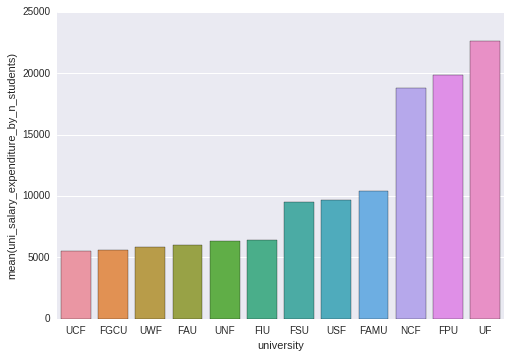

In [11]:
k = 'uni_salary_expenditure_by_n_students'
total_uni_sal_by_student_pop = pd.DataFrame({k: total_uni_sal_by_student_pop})
total_uni_sal_by_student_pop = total_uni_sal_by_student_pop.reset_index()
total_uni_sal_by_student_pop = total_uni_sal_by_student_pop.rename_axis({'index': 'university'}, axis=1)
total_uni_sal_by_student_pop[k] = total_uni_sal_by_student_pop[k].astype('float')
sns.barplot(x='university', y=k, data=total_uni_sal_by_student_pop)

### Repeat analysis faceted by faculty, administration, and staff

The above is with respect to all titles, some of which are faculty, some of which are administration, most of which are staff.

In [12]:
titles = df['class_title'].unique()
titles

array(['PROFESSOR', 'ASSOCIATE PROFESSOR', 'INSTRUCTOR', ...,
       'INTERNAL AUDITOR III', 'PROCUREMENT AGENT',
       'ASSOC. DEAN, STUDENT AFFAIRS'], dtype=object)

#### Identify faculty titles

We string match to help identify faculty titles.
* Helpful for identifying keywords: [Wiki - Academic ranks in the United States](https://en.wikipedia.org/wiki/Academic_ranks_in_the_United_States) 

In [13]:
FAC_KEY_WORDS = ['professor', 'faculty', 'instructor', 'lecturer']
fac_matches = []
for T in titles:
    t = str(T).lower()
    for kw in FAC_KEY_WORDS:
        if kw in t:
            fac_matches.append(T)

In [14]:
#First ten potential matches
fac_matches[:10]

['PROFESSOR',
 'ASSOCIATE PROFESSOR',
 'INSTRUCTOR',
 'UNIVERSITY SCHOOL INSTRUCTOR',
 'ASSISTANT PROFESSOR',
 'FACULTY ADMINISTRATOR',
 'UNIVERSITY SCHOOL ASSISTANT PROFESSOR',
 'INSTRUCTOR, LIBRARIAN',
 'LECTURER',
 'DISTINGUISHED PROFESSOR']

I filter this list appropriately to exclude admin and staff (e.g. 'DIR FACULTY DEV COM')

In [15]:
faculty_titles = ['PROFESSOR', 'ASSOCIATE PROFESSOR', 'INSTRUCTOR', 'UNIVERSITY SCHOOL INSTRUCTOR',
                  'ASSISTANT PROFESSOR', 'UNIVERSITY SCHOOL ASSISTANT PROFESSOR', 'INSTRUCTOR LIBRARIAN', 
                  'LECTURER', 'DISTINGUISHED PROFESSOR','FACULTY (GENERIC)',
                  'UNIVERSITY SCHOOL ASSOCIATE PROFESSOR','UNIVERSITY SCHOOL PROFESSOR',
                  'GRADUATE RESEARCH PROFESSOR', 'PROVOST/ASSOC. PROFESSOR','ADJUNCT FACULTY',
                  'DEAN/ASSOCIATE PROFESSOR','INSTRUCTOR I','ASSOC PROFESSOR']

I use this list to define what titles are faculty, and then create an indicator variable on the data

#### Identify admin titles 

Similary, we do the same for administration

In [16]:
ADMIN_KEY_WORDS = ['president', 'chancellor', 'registrar'
                   'board' 'admin', 'provost', 'dean', 'vp']
admin_matches = []
for T in titles:
    t = str(T).lower()
    for kw in ADMIN_KEY_WORDS:
        if kw in t:
            #set_trace()
            admin_matches.append(T)

In [17]:
#First ten potential matches
admin_matches[:10]

['ASSOC VP STUDENT AFFAIRS',
 'ASST VP,ACADEMIC AFFAIRS',
 'ASST VP, ADMIN & FINANCIAL SVC',
 'ASST VP STUDENT AFFAIRS',
 'ASSOC VP, INFORMATI TECHNOLOGY',
 'VP, FINANCE & ADMINISTRATI/CFO',
 'VP, UNIVERSITY ADVANCEMENT',
 'ASSC VP, ADVANCE/ALUMNI AFFAIR',
 'ASSOC VP FINANCE & ADMINISTRAT',
 'VP STUDENT AFFAIRS']

This list was checked to exclude faculty and staff. Administrative assistants were kept.

In [18]:
admin_titles = admin_matches

### Identify staff

Lastly, the remainder of titles will be considered as staff.

In [19]:
staff_titles = set(titles).difference(faculty_titles).difference(admin_titles)

### Add Indicator variable

In [20]:
def identify_position(x):
    if x in faculty_titles:
        return 'faculty'
    elif x in admin_titles:
        return 'admin'
    else:
        return 'staff'

In [21]:
df['position_indicator'] = df['class_title'].apply(identify_position)

### Breakdown salary info by title indicator

In [22]:
sal_by_uni_and_title = df.groupby(['university', 'position_indicator']).apply(lambda x: np.sum(x['annual_salary'].dropna()))
sal_by_uni_and_title = pd.DataFrame({'salary_expenditure': sal_by_uni_and_title})
#Get counts of the number of positions for each title type
sal_by_uni_and_title['N_pos'] = df.groupby(['university', 'position_indicator']).apply(lambda x: len(x['annual_salary'].dropna()))
#Compute mean salary by type and uni
sal_by_uni_and_title['mean_salary_per_pos'] = sal_by_uni_and_title['salary_expenditure'] / \
                                                         sal_by_uni_and_title['N_pos']

In [23]:
sal_exp_per_student = sal_by_uni_and_title.reset_index(level='position_indicator')['salary_expenditure'] / latest_pop
sal_exp_per_student = sal_exp_per_student.reset_index(drop=True)
sal_by_uni_and_title = sal_by_uni_and_title.reset_index()
sal_by_uni_and_title['sal_exp_per_student'] = sal_exp_per_student
sal_by_uni_and_title = sal_by_uni_and_title.sort_values(['university', 'position_indicator'])

#### Salary expenditure by university and position type, normalized by number of positions

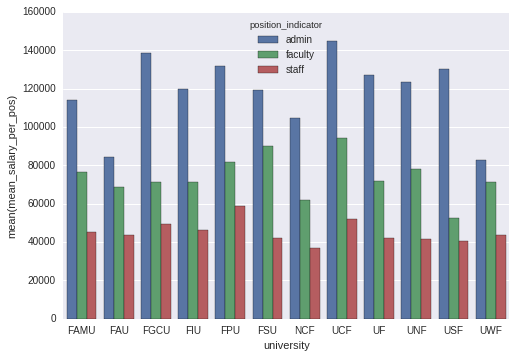

In [32]:
sns.barplot(x='university', y='mean_salary_per_pos', hue='position_indicator', data=sal_by_uni_and_title)


#### Salary expenditure by university and position type, normalized by the number of students

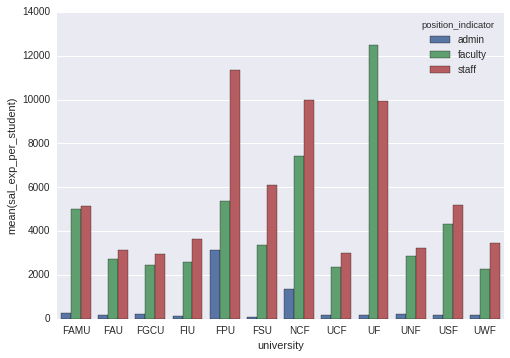

In [25]:
sns.barplot(x='university', y='sal_exp_per_student', hue='position_indicator', data=sal_by_uni_and_title)

Interestingly, FAMU does not have any matches for admins (as measured by my filter).

### Distributions of salaries by position type

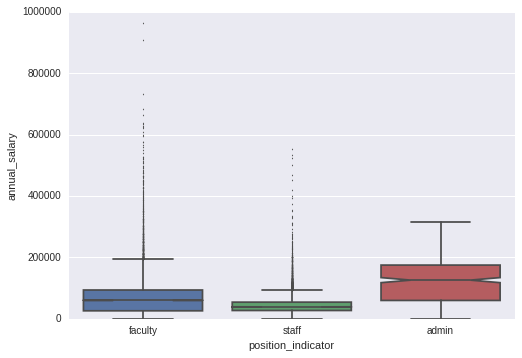

In [30]:
sns.boxplot(y = "annual_salary", x = "position_indicator", data=df, notch = True, fliersize=1.5)

### Distributions of salaries by position type and school

The plot indicates that the median salary for faculty is lower than that of the administration. However, the faculty have a much greater range than the administration, with many outliers.

### Compile PDF

In [38]:
!jupyter nbconvert vr3-assignment-03.ipynb --to=pdf --template=latex_nocode.tplx

[NbConvertApp] Converting notebook vr3-assignment-03.ipynb to pdf
[NbConvertApp] Support files will be in vr3-assignment-03_files/
[NbConvertApp] Making directory vr3-assignment-03_files
[NbConvertApp] Making directory vr3-assignment-03_files
[NbConvertApp] Making directory vr3-assignment-03_files
[NbConvertApp] Making directory vr3-assignment-03_files
[NbConvertApp] Writing 15796 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running pdflatex 3 times: ['pdflatex', 'notebook.tex']
[NbConvertApp] PDF successfully created
[NbConvertApp] Support files will be in vr3-assignment-03_files/
[NbConvertApp] Making directory vr3-assignment-03_files
[NbConvertApp] Making directory vr3-assignment-03_files
[NbConvertApp] Making directory vr3-assignment-03_files
[NbConvertApp] Making directory vr3-assignment-03_files
[NbConvertApp] Writing 135636 bytes to vr3-assignment-03.pdf
